In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1751
[LightGBM] [Info] Number of data points in the train set: 1355, number of used features: 9
[LightGBM] [Info] Start training from score 20.205018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.76875e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.57589e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.5801e-19): result may not be 

Polynomial Regression - Best Degree: 2
Polynomial Regression - Best Alpha: 0.1
Polynomial Regression - R² Score: 1.000
Polynomial Regression - RMSE: 0.123
Polynomial Regression - MAE: 0.083


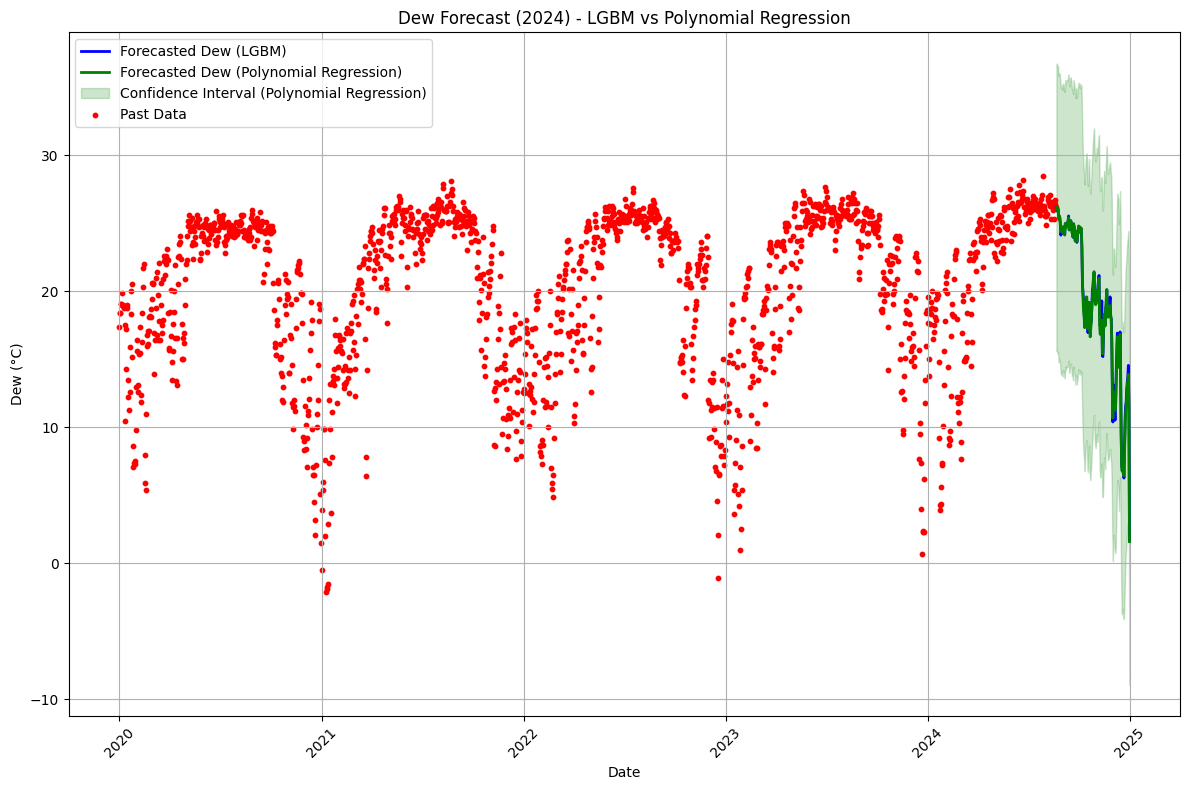

In [4]:
# Load the dataset
file_path = '../../dataset/Data.csv' # Adjust the path to your dataset
data = pd.read_csv(file_path)

# Prepare the data
data['datetime'] = pd.to_datetime(data['datetime'], format='%m/%d/%Y')
data['day_of_year'] = data['datetime'].dt.dayofyear

# Extract features and labels
X = data[['temp', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'sealevelpressure', 'humidity', 'day_of_year']]
y = data['dew']

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


# Initialize the LightGBM model
lgbm_model = LGBMRegressor(random_state=42)

# Define the parameter grid for fine-tuning
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

best_lgb_model = grid_search.best_estimator_

y_pred_lgb = best_lgb_model.predict(X_test)

r2_lgb = r2_score(y_test, y_pred_lgb)
rmse_lgb = mean_squared_error(y_test, y_pred_lgb, squared=False)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)

# Display the performance metrics for XGBoost
print(f"Lgbm- R² Score: {r2_lgb:.5f}")
print(f"Lgbm - RMSE: {rmse_lgb:.5f}")
print(f"Lgbm - MAE: {mae_lgb:.5f}")
print(f"Best Parameters: {grid_search.best_params_}")

# Polynomial Regression for comparison
def create_model(degree, alpha):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    model = Ridge(alpha=alpha)
    model.fit(X_train_poly, y_train)
    return model, poly

# Manual grid search for Polynomial Regression
param_grid_poly = {
    'degree': [2, 3, 4, 5],
    'alpha': [0.1, 1, 10]
}

best_model_poly = None
best_poly = None
best_score_poly = float('-inf')

# Perform manual tuning for simplicity
for degree in param_grid_poly['degree']:
    for alpha in param_grid_poly['alpha']:
        model_poly, poly = create_model(degree, alpha)
        X_test_poly = poly.transform(X_test)
        y_pred_poly = model_poly.predict(X_test_poly)
        score_poly = r2_score(y_test, y_pred_poly)

        if score_poly > best_score_poly:
            best_score_poly = score_poly
            best_model_poly = model_poly
            best_poly = poly

# Calculate R², RMSE, and MAE for Polynomial Regression
X_test_poly = best_poly.transform(X_test)
y_pred_poly = best_model_poly.predict(X_test_poly)
r2_poly = r2_score(y_test, y_pred_poly)
rmse_poly = mean_squared_error(y_test, y_pred_poly, squared=False)
mae_poly = mean_absolute_error(y_test, y_pred_poly)

# Display the performance metrics for Polynomial Regression
print(f"Polynomial Regression - Best Degree: {best_poly.degree}")
print(f"Polynomial Regression - Best Alpha: {best_model_poly.alpha}")
print(f"Polynomial Regression - R² Score: {r2_poly:.3f}")
print(f"Polynomial Regression - RMSE: {rmse_poly:.3f}")
print(f"Polynomial Regression - MAE: {mae_poly:.3f}")

# Generate future dates (from 21/08/2024 to 31/12/2024)
future_dates = pd.date_range('2024-08-21', '2024-12-31')
future_day_of_year = future_dates.dayofyear
future_data = pd.DataFrame({
    'day_of_year': future_day_of_year,
    'year': future_dates.year
})

# Use historical averages for future features
historical_averages = data.groupby('day_of_year')[['temp', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'sealevelpressure', 'humidity']].mean()
future_features = pd.DataFrame({
    'temp': [historical_averages.loc[day, 'temp'] for day in future_day_of_year],
    'tempmax': [historical_averages.loc[day, 'tempmax'] for day in future_day_of_year],
    'tempmin': [historical_averages.loc[day, 'tempmin'] for day in future_day_of_year],
    'feelslikemax': [historical_averages.loc[day, 'feelslikemax'] for day in future_day_of_year],
    'feelslikemin': [historical_averages.loc[day, 'feelslikemin'] for day in future_day_of_year],
    'feelslike': [historical_averages.loc[day, 'feelslike'] for day in future_day_of_year],
    'sealevelpressure': [historical_averages.loc[day, 'sealevelpressure'] for day in future_day_of_year],
    'humidity': [historical_averages.loc[day, 'humidity'] for day in future_day_of_year],
    'day_of_year': future_day_of_year
})

# Predict future dew using XGBoost
future_forecast_lgb = best_lgb_model.predict(future_features)

# Apply polynomial transformation on future features and predict using Polynomial Regression
future_features_poly = best_poly.transform(future_features)
future_forecast_poly = best_model_poly.predict(future_features_poly)

# Calculate confidence intervals for Polynomial Regression
std_dev_poly = np.std(future_forecast_poly)
lower_bound_poly = future_forecast_poly - 1.96 * std_dev_poly
upper_bound_poly = future_forecast_poly + 1.96 * std_dev_poly


# Create DataFrame for XGBoost and Polynomial Regression predictions
future_data['dew_forecast_lgb'] = future_forecast_lgb
future_data['dew_forecast_poly'] = future_forecast_poly
future_data['lower_bound_poly'] = lower_bound_poly
future_data['upper_bound_poly'] = upper_bound_poly
future_data['ds'] = future_dates

# Save predictions to CSV
future_data[['ds', 'dew_forecast_lgb', 'dew_forecast_poly', 'lower_bound_poly', 'upper_bound_poly']].to_csv('dew_forecast_lgb_poly_2024.csv', index=False)

# Plot the forecasted dew
plt.figure(figsize=(12, 8))

# LGB predictions
plt.plot(future_data['ds'], future_data['dew_forecast_lgb'], color='blue', label='Forecasted Dew (LGBM)', linewidth=2)

# Polynomial Regression predictions with confidence intervals
plt.plot(future_data['ds'], future_data['dew_forecast_poly'], color='green', label='Forecasted Dew (Polynomial Regression)', linewidth=2)
plt.fill_between(future_data['ds'], future_data['lower_bound_poly'], future_data['upper_bound_poly'], color='green', alpha=0.2, label='Confidence Interval (Polynomial Regression)')

# Historical data
plt.scatter(data['datetime'], data['dew'], color='red', label='Past Data', s=10)

# Add labels and title
plt.title("Dew Forecast (2024) - LGBM vs Polynomial Regression")
plt.xlabel("Date")
plt.ylabel("Dew (°C)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
